# Running and Plotting LightCones

This tutorial follows on from the coeval cube tutorial, and provides an introduction to creating lightcones with ``21cmFAST``. If you are new to ``21cmFAST`` you should go through the coeval cube tutorial first.

There are two ways of creating lightcones in ``21cmFAST``: manual and automatic. The manual way involves evolving a coeval simulation through redshift and saving slices of it into a lightcone array. The advantage of this method is that one can precisely choose the redshift nodes to simulate and decide on interpolation methods. However, in this tutorial, we will focus on the single function that is included to do this for you: ``run_lightcone``. 

The function takes a few different arguments, most of which will be familiar to you if you've gone through the coeval tutorial. All simulation parameters can be passed (i.e. ``user_params``, ``cosmo_params``, ``flag_options`` and ``astro_params``). As an alternative to the first two, an ``InitialConditions`` and/or ``PerturbField`` box can be passed. 

Furthermore, the evolution can be managed with the ``z_step_factor`` and ``z_heat_max`` arguments. 

Finally, the final *minimum* redshift of the lightcone is set by the ``redshift`` argument, and the maximum redshift of the lightcone is defined by the ``max_redshift`` argument (note that this is not the maximum redshift evaluated, which is controlled by ``z_heat_max``, merely the maximum saved into the returned lightcone). 

Let's see what it does. We won't use the spin temperature, just to get a simple toy model:

In [1]:
import py21cmfast as p21c
from py21cmfast import plotting

print(f"21cmFAST version is {p21c.__version__}")

21cmFAST version is 3.0.0dev


In [3]:
lightcone = p21c.run_lightcone(
    redshift = 7.0,
    max_redshift = 12.0,
    user_params = {"HII_DIM":150, "BOX_LEN": 600}
)

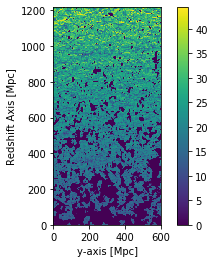

In [4]:
plotting.lightcone_sliceplot(lightcone);

Simple!